In [1]:
import sys, os, inspect

sys.path.append('../lib/')
sys.path.append('../sim_lib/')

def ospath(paths):
    if ('win32' in sys.platform):
        if type(paths)==list or type(paths)==tuple:
            paths = [fn.replace('/c/','c:\\').replace('/', '\\') for fn in paths]
        else:
            paths = paths.replace('/c/','c:\\').replace('/', '\\')
        #print(mltd_paths)
    return paths

import numpy as np

import logging
logger = logging.getLogger('stochastic_ir')
hdlr = logging.FileHandler('./stochastic_ir.log')
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr) 
logger.setLevel(logging.INFO)

from  matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import datetime
import copy
import pickle

import multiprocessing as mp
import ctypes as c
import gc
import importlib

#ASOFDATE = datetime.datetime(2020, 4, 30)

In [2]:
import scipy.optimize as opt
import scipy.integrate as integrate
from scipy.integrate import simps
from scipy.integrate import cumtrapz
import scipy.interpolate

In [3]:
import json

In [4]:
import calibrator
import interpolator
import surfaces

# Read Implied Vol, correlations, EUR and USD DF curves

In [5]:
MARKETDATA = '../marketdata_JSON_asof_04_30_2020/'
with open(MARKETDATA+'EUR.json', 'r') as f:
    eurdata = json.load(f)
with open(MARKETDATA+'USD.json', 'r') as f:
    usddata = json.load(f)
with open(MARKETDATA+'EURUSD.json', 'r') as f:
    eurusddata = json.load(f)

In [6]:
with open(MARKETDATA+'correlations.json', 'r') as f:
    correlations = json.load(f)

In [7]:
rho_domestic_base = correlations['USD_EUR']
rho_base_fx = correlations['EUR_EURUSD']
rho_domestic_fx = correlations['USD_EURUSD']

In [8]:
base_ta = eurdata['g1++']['meanrev']['times']
base_a = eurdata['g1++']['meanrev']['values']
base_tvol = eurdata['g1++']['vol']['times']
base_vol = eurdata['g1++']['vol']['values']
base_x0 = eurdata['g1++']['x0']
base_shifttimes = eurdata['g1++']['shift']['times']
base_shiftvalues = eurdata['g1++']['shift']['values']

In [9]:
domestic_ta = usddata['g1++']['meanrev']['times']
domestic_a = usddata['g1++']['meanrev']['values']
domestic_tvol = usddata['g1++']['vol']['times']
domestic_vol = usddata['g1++']['vol']['values']
domestic_x0 = usddata['g1++']['x0']
domestic_shifttimes = usddata['g1++']['shift']['times']
domestic_shiftvalues = usddata['g1++']['shift']['values']

In [10]:
fxvoldata = eurusddata['impliedvol']
spot_FX = eurusddata['spot']

In [11]:
base_dfcurve = interpolator.InterpolatedCurve(eurdata['discount']['times'],
                                              eurdata['discount']['values'])
dfcurve = interpolator.InterpolatedCurve(usddata['discount']['times'], 
                                         usddata['discount']['values'])

# Interpolate Implied Vol

In [12]:
import fxivolinterpolator as fxvol

In [13]:
fxvolsurf = fxvol.FXIVolInterpolator(eurusddata['impliedvol'], 
                                     eurusddata['spot'], dfcurve, base_dfcurve)

# SetUp Calibration slices and Number of Spots

In [14]:
def get_unique_from_sorted_array(arrvals, tolerance=1e-6):
    #tolerance = 1e-6
    idxmask = (arrvals[1:] - arrvals[:-1])<tolerance
    return arrvals[:-1][~idxmask]

DETERMINISTIC = False #True #
WITH_CALL_SURFACE = False #True #
LOCALVOL_CAP = 1.0

IS_LOCVOL_RECTANGULAR=False
IMPLIEDVOL_NRY_FX = 100

IMPLIEDVOL_TIMES_FX = np.array(sorted(fxvolsurf.times + [0.025] + list(np.arange(0.05, 1.00, 0.05))))
IMPLIEDVOL_TIMES_FX = get_unique_from_sorted_array(IMPLIEDVOL_TIMES_FX)

LOCALVOL_NRSPOTS_FX = 100
LOCALVOL_TIMES_FX = [0.02, 0.03, 0.04] + list(np.arange(0.05, 1.00, 0.05)) 

OUTPUTDIR = 'output_LV_2SIR/'
nr_mcruns = 100000

In [15]:
import StochasticSim_Multiprocessing as simulator

In [16]:
if WITH_CALL_SURFACE:
    surface = surfaces.generate_call_price_surface_nonuniform(
                    fxvolsurf, IMPLIEDVOL_NRY_FX, IMPLIEDVOL_TIMES_FX, 
                    dfcurve, base_dfcurve, spot_FX,
                    localvol_cap=LOCALVOL_CAP, width_nr_stdev=3.6)
else:
    surface = surfaces.generate_tiv_surface_nonuniform(
                    fxvolsurf, IMPLIEDVOL_NRY_FX, IMPLIEDVOL_TIMES_FX, 
                    dfcurve, base_dfcurve, spot_FX,
                    localvol_cap=LOCALVOL_CAP, width_nr_stdev=3.6)

Creating implied total variance interpolator
Created implied total variance interpolator


In [30]:
if 'locvol_sim' in locals() or 'locvol_sim' in globals():
    locvol_sim.delete_all()
    del(locvol_sim)
    print('Deleted lvolsim')

Deleting Xs...
Deleting RB...
Deleting RD...
Deleted lvolsim


In [31]:
nr_mcruns = 100000 ### number of calibration runs
NRSUBSIM = 5  ### number of multiprocessing sub-processes 
LVOL_NUMMETHOD = 'ForwardEuler'
SHORTRATE_NUMMETHOD = 'ForwardEuler'
ANTITHETIC = True

if DETERMINISTIC: 
    locvol_sim=None
else:
    locvol_sim = simulator.LocalVolStochasticIRSimulation(
                    domestic_shifttimes, domestic_shiftvalues, 
                    base_shifttimes, base_shiftvalues, spot_FX,
                    domestic_ta, domestic_a, domestic_tvol, 
                    domestic_vol, domestic_x0,
                    base_ta, base_a, base_tvol, base_vol, base_x0,
                    rho_domestic_base, rho_domestic_fx, rho_base_fx,
                    nr_mcruns, LVOL_NUMMETHOD, SHORTRATE_NUMMETHOD,
                    antitheticpaths=ANTITHETIC,
                    in_forward_measure=True,
                    nrsubsim=NRSUBSIM,
                    )

in_forward_measure =True, Antithetic=True, in_DRN=True, det_DR=False, det_FR=False, DLV=True
Allocating shmem ...XS RD RB 
Allocating shmem ...XS RD RB 
Allocating shmem ...XS RD RB 
Allocating shmem ...XS RD RB 
Allocating shmem ...XS RD RB 
Initializing pool for ... <class 'StochasticSim_Multiprocessing.LocalVolStochasticIRSimulation'>


In [32]:
LVOL_FILENAME = 'lvolsample%s_%s_%s.pkl' % ('_d' if DETERMINISTIC else '', 
                                            nr_mcruns, 
                                            'CallInterp' if WITH_CALL_SURFACE else 'VolInterp')

logger.info('Calibrating vol surface for nr_mcruns:%s in filename:%s'%(nr_mcruns, LVOL_FILENAME))
print(LVOL_FILENAME)

lvolsample_100000_VolInterp.pkl


In [33]:
if DETERMINISTIC:
    locvol_cal = calibrator.DeterministicLocalVolDeterministicIRCalibration(
                    surface, locvol_sim,
                    filename= OUTPUTDIR + LVOL_FILENAME,
                    )
else:
    locvol_cal = calibrator.DeterministicLocalVolStochasticIRCalibration(
                    surface, locvol_sim,
                    filename= OUTPUTDIR + LVOL_FILENAME,
                    )
            

In [34]:
strike_grid = surfaces.generate_2d_strike_grid(surface, 
                                               LOCALVOL_NRSPOTS_FX, 
                                               LOCALVOL_TIMES_FX, 
                                               IS_LOCVOL_RECTANGULAR, 
                                               width_nr_stdev=3.5)

In [35]:
locvols = locvol_cal.calibrate_localvol(strike_grid, LOCALVOL_TIMES_FX)

Processing time: 0.020000
Written: output_LV_2SIR/lvolsample_100000_VolInterp.pkl
Processing time: 0.030000
0.03 250
ProcessID:0, n_trials:20000, maturity:0.030, timesteps:7
ProcessID:1, n_trials:20000, maturity:0.030, timesteps:7
ProcessID:2, n_trials:20000, maturity:0.030, timesteps:7
ProcessID:3, n_trials:20000, maturity:0.030, timesteps:7
ProcessID:4, n_trials:20000, maturity:0.030, timesteps:7
Recomputing localvol means and stderr from output...
Written: output_LV_2SIR/lvolsample_100000_VolInterp.pkl
Processing time: 0.040000
0.04 250
ProcessID:0, n_trials:20000, maturity:0.040, timesteps:10
ProcessID:1, n_trials:20000, maturity:0.040, timesteps:10
ProcessID:2, n_trials:20000, maturity:0.040, timesteps:10
ProcessID:3, n_trials:20000, maturity:0.040, timesteps:10
ProcessID:4, n_trials:20000, maturity:0.040, timesteps:10
Recomputing localvol means and stderr from output...
Written: output_LV_2SIR/lvolsample_100000_VolInterp.pkl
Processing time: 0.050000
0.05 250
ProcessID:0, n_trial

Recomputing localvol means and stderr from output...
Written: output_LV_2SIR/lvolsample_100000_VolInterp.pkl
Processing time: 0.850000
0.8500000000000001 250
ProcessID:0, n_trials:20000, maturity:0.850, timesteps:212
ProcessID:1, n_trials:20000, maturity:0.850, timesteps:212
ProcessID:2, n_trials:20000, maturity:0.850, timesteps:212
ProcessID:3, n_trials:20000, maturity:0.850, timesteps:212
ProcessID:4, n_trials:20000, maturity:0.850, timesteps:212
Recomputing localvol means and stderr from output...
Written: output_LV_2SIR/lvolsample_100000_VolInterp.pkl
Processing time: 0.900000
0.9000000000000001 250
ProcessID:0, n_trials:20000, maturity:0.900, timesteps:225
ProcessID:1, n_trials:20000, maturity:0.900, timesteps:225
ProcessID:2, n_trials:20000, maturity:0.900, timesteps:225
ProcessID:3, n_trials:20000, maturity:0.900, timesteps:225
ProcessID:4, n_trials:20000, maturity:0.900, timesteps:225
Recomputing localvol means and stderr from output...
Written: output_LV_2SIR/lvolsample_100000

In [36]:
lvol_data = {}
lvol_data['surfacevalues'] = locvols
lvol_data['times'] = LOCALVOL_TIMES_FX
lvol_data['spots'] = strike_grid
lvol_all = locvols
strikes_all = strike_grid
tslices = LOCALVOL_TIMES_FX

(21, 100) (21, 100) (21, 100)


Text(0.5, 0.92, 'Local Vol surface')

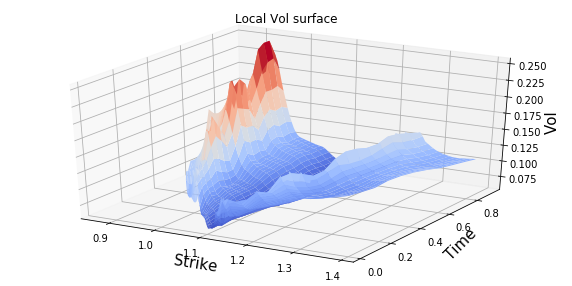

In [37]:
fig = plt.figure(figsize=(10,5))
plotid=1
num_slices=-1
X_lvol = np.array(strikes_all[:num_slices]) 
Y_lvol = np.array([tslices[:num_slices]]*X_lvol.shape[1]).T
Z_lvol = np.array(lvol_all[:num_slices])
print(X_lvol.shape, Y_lvol.shape, Z_lvol.shape)

ax = fig.add_subplot(1, 1, plotid, projection='3d')
surf = ax.plot_surface(X_lvol, Y_lvol, Z_lvol, 
                       cmap=cm.coolwarm, linewidth=1, antialiased=True)
ax.set_zlabel('Vol', fontsize=15, rotation = 90)
ax.set_ylabel('Time', fontsize=15, rotation = 45)
ax.set_xlabel('Strike', fontsize=15, rotation = 0)

ax.set_title('Local Vol surface')

# Analytical Call Surface for Comparison

In [38]:
import bsanalytic as bsan

In [39]:
callsurf_all = []
for tval,strikevals in zip(tslices, strikes_all):
    reff = -np.log(dfcurve(tval))/tval
    qeff = -np.log(base_dfcurve(tval))/tval
    ivol_ref = np.array([fxvolsurf.impliedvol_K(tval, K) for K in strikevals])
    callprices = bsan.Call(spot_FX, np.array(strikevals), tval, reff, qeff, ivol_ref)
    callsurf_all.append(callprices)

(21, 100) (21, 100) (21, 100)


Text(0.5, 0.92, 'Call Surface')

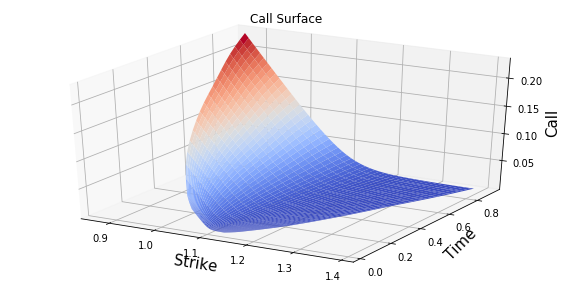

In [40]:
fig = plt.figure(figsize=(10,5))
plotid=1
num_slices=-1
X_Callsurf = np.array(strikes_all[:num_slices])
Y_Callsurf = np.array([tslices[:num_slices]]*X_Callsurf.shape[1]).T
Z_Callsurf = np.array(callsurf_all[:num_slices])
print(X_Callsurf.shape, Y_Callsurf.shape, Z_Callsurf.shape)

ax = fig.add_subplot(1, 1, plotid, projection='3d')
surf = ax.plot_surface(X_Callsurf, Y_Callsurf, Z_Callsurf, 
                       cmap=cm.coolwarm, linewidth=1, antialiased=True)
ax.set_zlabel('Call', fontsize=15, rotation = 90)
ax.set_ylabel('Time', fontsize=15, rotation = 45)
ax.set_xlabel('Strike', fontsize=15, rotation = 0)
ax.set_title('Call Surface')

# Start Pricing Runs

In [41]:
if 'locvol_sim' in locals() or 'locvol_sim' in globals():
    locvol_sim.delete_all()
    del(locvol_sim)
    print('Deleted lvolsim')

Deleting Xs...
Deleting RB...
Deleting RD...
Deleted lvolsim


In [42]:
nr_simruns = 100000
NRSUBSIM = 5
LVOL_NUMMETHOD = 'ForwardEuler' #'Milstein'
SHORTRATE_NUMMETHOD = 'ForwardEuler' #'PredictorCorrectorForwardEuler'
ANTITHETIC = True

locvol_sim = simulator.LocalVolStochasticIRSimulation(
                  domestic_shifttimes, domestic_shiftvalues,
                    base_shifttimes, base_shiftvalues, spot_FX,
                    domestic_ta, domestic_a, domestic_tvol, domestic_vol, domestic_x0,
                    base_ta, base_a, base_tvol, base_vol, base_x0,
                    rho_domestic_base, rho_domestic_fx, rho_base_fx,
                    nr_simruns, LVOL_NUMMETHOD, SHORTRATE_NUMMETHOD,
                    antitheticpaths=ANTITHETIC,
                    in_forward_measure=False,
                    nrsubsim=NRSUBSIM,
                  )

in_forward_measure =False, Antithetic=True, in_DRN=True, det_DR=False, det_FR=False, DLV=True
Allocating shmem ...XS RD RB 
Allocating shmem ...XS RD RB 
Allocating shmem ...XS RD RB 
Allocating shmem ...XS RD RB 
Allocating shmem ...XS RD RB 
Initializing pool for ... <class 'StochasticSim_Multiprocessing.LocalVolStochasticIRSimulation'>


In [43]:
expiry = 1.0
locvol_sim.update_domestic_bfactors(expiry)
locvol_sim.update_localvol(lvol_data['spots'], lvol_data['times'], lvol_data['surfacevalues'])
locvol_sim.run()

ProcessID:0, n_trials:20000, maturity:1.000, timesteps:250
ProcessID:1, n_trials:20000, maturity:1.000, timesteps:250
ProcessID:2, n_trials:20000, maturity:1.000, timesteps:250
ProcessID:3, n_trials:20000, maturity:1.000, timesteps:250
ProcessID:4, n_trials:20000, maturity:1.000, timesteps:250


### Collect Results from Subprocesses

In [44]:
n_timesteps = locvol_sim.tdisargs['time_steps']
n_trials_per_process = locvol_sim.n_paths_per_process
tdisargs = locvol_sim.tdisargs['time_steps']
dtype_glob=locvol_sim.dtype_glob

In [45]:
Xsamples = np.concatenate([np.frombuffer(xs, dtype=dtype_glob)
                           .reshape((n_trials_per_process, -1))[:,:n_timesteps+1] 
                           for xs in locvol_sim.Xsamples_raw], axis=0)

rd = np.concatenate([np.frombuffer(rds, dtype=dtype_glob)
                     .reshape((n_trials_per_process, -1))[:,:n_timesteps] 
                     for rds in locvol_sim.rd_raw], axis=0)

rb = np.concatenate([np.frombuffer(rbs, dtype=dtype_glob)
                     .reshape((n_trials_per_process, -1))[:,:n_timesteps] 
                     for rbs in locvol_sim.rb_raw], axis=0)

tstamps = np.concatenate([np.frombuffer(ts, dtype=dtype_glob)
                          .reshape((1, -1))[:,:n_timesteps] 
                          for ts in locvol_sim.t_stamp_raw], axis=0) 

## MC Call Surface

In [46]:
#Call price Simulator
t_stamp = tstamps[0]
Values_call = []
StdErr_call = []
Values_put = []
StdErr_put = []
Strikes_finaldict = []
finaldict={}
finaldict['MCMean'] = {}
finaldict['MCStdErr'] = {}
def calc_mc(X, K, df, option_type='call'):
    mcval = np.maximum(X-K, 0)*df if option_type.lower()=='call' else np.maximum(K-X, 0)*df 
    mcmean = np.mean(mcval)
    mcerr = np.std(mcval-mcmean)/np.sqrt(X.shape[0])
    return mcmean, mcerr

from itertools import compress

for tidx, t in enumerate(list(compress(tslices, tslices<t_stamp[-1]))): #[:num_slices]):
    idx = np.searchsorted(t_stamp, t) # max(0, np.searchsorted(t_stamp, t)-1)
    strikes = strikes_all[tidx]
    domestic_df = dfcurve(t)
    print('t=%.3f, idx=%d'%(t, idx))
    MCMean_call, MCErr_call = zip(*[calc_mc(Xsamples[:,idx], K, domestic_df, option_type='call') for K in strikes])
    MCMean_put, MCErr_put = zip(*[calc_mc(Xsamples[:,idx], K, domestic_df, option_type='put') for K in strikes])
    Values_call.append(list(MCMean_call))
    StdErr_call.append(list(MCErr_call))
    Values_put.append(list(MCMean_put))
    StdErr_put.append(list(MCErr_put))
    Strikes_finaldict.append(strikes)
    #Calls_all.append([np.mean(np.maximum(Xsamples[:,idx] - K, 0))*domestic_df for K in strikes])
    #StdErr_all.append([1.0e-5 for K in strikes])
    
finaldict['Strike'] = Strikes_finaldict #[:num_slices]
finaldict['Expiry'] = list(compress(tslices, tslices<t_stamp[-1])) #tslices[tslices<t_stamp[-1]] #[:num_slices]
finaldict['MCMean']['call'] = Values_call
finaldict['MCStdErr']['call'] = StdErr_call
finaldict['MCMean']['put'] = Values_put
finaldict['MCStdErr']['put'] = StdErr_put

t=0.020, idx=5
t=0.030, idx=8
t=0.040, idx=10
t=0.050, idx=13
t=0.100, idx=25
t=0.150, idx=38
t=0.200, idx=50
t=0.250, idx=63
t=0.300, idx=75
t=0.350, idx=88
t=0.400, idx=100
t=0.450, idx=113
t=0.500, idx=125
t=0.550, idx=138
t=0.600, idx=151
t=0.650, idx=163
t=0.700, idx=175
t=0.750, idx=188
t=0.800, idx=200
t=0.850, idx=213
t=0.900, idx=226
t=0.950, idx=238


(22, 100) (22, 100) (22, 100)


Text(0.5, 0.92, 'MC Call Surface')

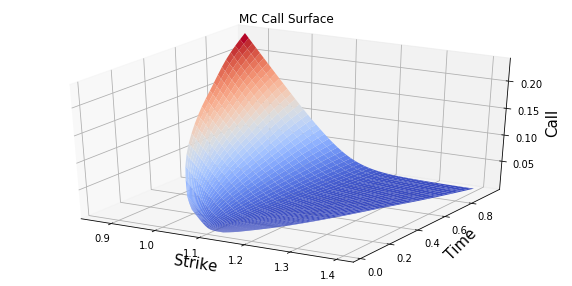

In [47]:
fig = plt.figure(figsize=(10,5))
plotid=1
X_Callsurf = np.array(finaldict['Strike'])
Y_Callsurf = np.array([finaldict['Expiry']]*X_Callsurf.shape[1]).T
Z_Callsurf = np.array(finaldict['MCMean']['call'])
print(X_Callsurf.shape, Y_Callsurf.shape, Z_Callsurf.shape)

ax = fig.add_subplot(1, 1, plotid, projection='3d') #fig.add_subplot(2, 2, plotid, projection='3d')
surf = ax.plot_surface(X_Callsurf, Y_Callsurf, Z_Callsurf, cmap=cm.coolwarm, linewidth=1, antialiased=True)
ax.set_zlabel('Call', fontsize=15, rotation = 90)
ax.set_ylabel('Time', fontsize=15, rotation = 45)
ax.set_xlabel('Strike', fontsize=15, rotation = 0)
#ax.set_zlim([0.05, 0.13])
ax.set_title('MC Call Surface')
#ax.view_init(20, 240)

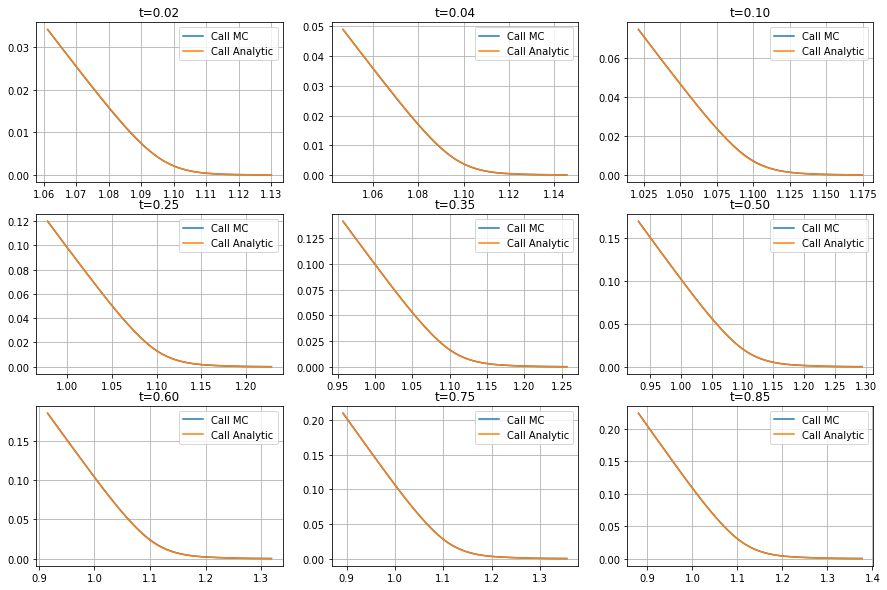

In [48]:
plt.figure(figsize=(15,10))
num_plots = 9
plt.text(10, 10, tdisargs)
for i1 in range(num_plots):
    idxval = int(i1*len(Strikes_finaldict)/num_plots)
    #print(idxval)
    ax = plt.subplot(3,3,i1+1)
    ax.plot(finaldict['Strike'][idxval], finaldict['MCMean']['call'][idxval], label='Call MC')
    ax.plot(finaldict['Strike'][idxval], callsurf_all[idxval], label='Call Analytic')
    ax.legend()
    ax.grid()
    ax.set_title('t=%.2f'%tslices[idxval])

# Implied Vol recovery at slices

In [49]:
reff_d = [-np.log(dfcurve(t))/t for t in finaldict['Expiry']]
reff_b = [-np.log(base_dfcurve(t))/t for t in finaldict['Expiry']]

In [50]:
ivol_mc = []
ivol_mcup = []
ivol_mcdn = []
ivol_market = []

ivolfunc = lambda S,K,ts,rd, rb, C, P, guess: bsan.impliedvol_call(S,K,ts,rd, rb, C, guess) if S>K else bsan.impliedvol_put(S,K,ts,rd, rb, P, guess)

S = spot_FX
bumpup = 2.0
bumpdn = 2.0
all_call = finaldict['MCMean']['call']
stderr_call = finaldict['MCStdErr']['call']
all_put = finaldict['MCMean']['put']
stderr_put = finaldict['MCStdErr']['put']

for idx,ts in enumerate(finaldict['Expiry']):
    ivol_mc.append([ivolfunc(S, K, ts, reff_d[idx],reff_b[idx], C, P, guess=0.1) for K,C,Ec,P,Ep 
                    in zip(finaldict['Strike'][idx], all_call[idx], stderr_call[idx], all_put[idx], stderr_put[idx])])
    
    ivol_mcup.append([ivolfunc(S, K, ts,reff_d[idx],reff_b[idx],C+bumpup*Ec,P+bumpup*Ep, guess=0.1) for K,C,Ec,P,Ep 
                      in zip(finaldict['Strike'][idx], all_call[idx], stderr_call[idx], all_put[idx], stderr_put[idx])])
    
    ivol_mcdn.append([ivolfunc(S, K, ts,reff_d[idx],reff_b[idx],C-bumpdn*Ec,P-bumpdn*Ep, guess=0.1) for K,C,Ec,P,Ep 
                      in zip(finaldict['Strike'][idx], all_call[idx], stderr_call[idx], all_put[idx], stderr_put[idx])])
    
    ivol_market.append([fxvolsurf.impliedvol_K(ts, K) for K in finaldict['Strike'][idx]])
    
    print('%d, %.3f, %.5f, %.5f, %.5f, %.5f'%(idx,ts, reff_d[idx], reff_b[idx], min(ivol_mc[-1]), max(ivol_mc[-1])))

C:\Users\U726005\AppData\Local\conda\conda\envs\cmor-windows\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0, 0.020, 0.00041, -0.00568, 0.06420, 0.07915
1, 0.030, 0.00042, -0.00572, 0.06645, 0.09542
2, 0.040, 0.00042, -0.00582, 0.06432, 0.09080
3, 0.050, 0.00043, -0.00596, 0.06565, 0.09665
4, 0.100, 0.00043, -0.00642, 0.06485, 0.09443
5, 0.150, 0.00044, -0.00669, 0.06534, 0.10186
6, 0.200, 0.00045, -0.00689, 0.06535, 0.10082
7, 0.250, 0.00045, -0.00702, 0.06582, 0.10431
8, 0.300, 0.00045, -0.00718, 0.06597, 0.10183
9, 0.350, 0.00045, -0.00732, 0.06621, 0.10237
10, 0.400, 0.00045, -0.00740, 0.06619, 0.10004
11, 0.450, 0.00045, -0.00740, 0.06646, 0.10590
12, 0.500, 0.00045, -0.00741, 0.06639, 0.11063
13, 0.550, 0.00045, -0.00757, 0.06696, 0.11251
14, 0.600, 0.00044, -0.00783, 0.06778, 0.11307
15, 0.650, 0.00044, -0.00806, 0.06820, 0.10996
16, 0.700, 0.00044, -0.00818, 0.06854, 0.11108
17, 0.750, 0.00044, -0.00819, 0.06883, 0.11388
18, 0.800, 0.00043, -0.00820, 0.06891, 0.11451
19, 0.850, 0.00043, -0.00825, 0.06916, 0.11615
20, 0.900, 0.00043, -0.00829, 0.06911, 0.11691
21, 0.950, 0.00043, -0.

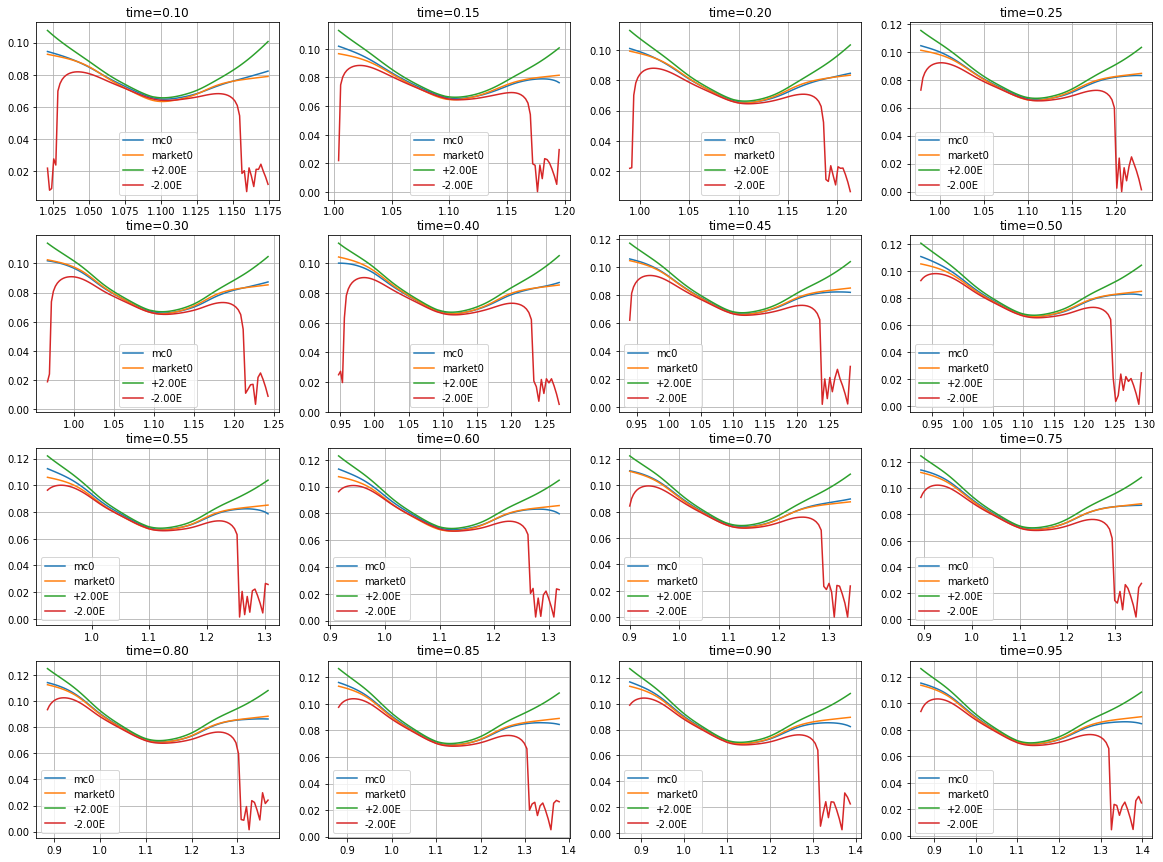

In [51]:
plt.figure(figsize=(20,15))
numplots = 16
till_time = 1.0 #0.5
maxtime = np.minimum(finaldict['Expiry'][-1], till_time)
show_delta = maxtime/numplots
for i1 in range(numplots):
    idxval = np.searchsorted(finaldict['Expiry'], (i1+1)*show_delta)
    ax = plt.subplot(4,4,i1+1)
    ax.plot(finaldict['Strike'][idxval], ivol_mc[idxval], label='mc0')
    ax.plot(finaldict['Strike'][idxval], ivol_market[idxval], label='market0')
    ax.plot(finaldict['Strike'][idxval], ivol_mcup[idxval], label='+%.2fE'%bumpup)
    ax.plot(finaldict['Strike'][idxval], ivol_mcdn[idxval], label='-%.2fE'%bumpdn)
    ax.legend()
    ax.set_title('time=%.2f'%finaldict['Expiry'][idxval])
    ax.grid()